# Transciption de l'algorithme NLSNIP en Julia

On considère le problème d'optimisation $\left\{ \begin{array}{l l l l} \underset{x \in \mathbb{R}^n}{\min} \dfrac{1}{2}\|r(x)\|^2 \\ \text{sous contraintes} \\ c_i(x) = 0 \text{ pour } i=1,\ldots q \\ 
c_j(x) \geq 0 \text{ pour } j=q+1,\ldots l
\end{array} \right.$

Avec $r : \mathbb{R}^n \mapsto \mathbb{R}^m$ la fonction objectif et $c_i:\mathbb{R}^n \mapsto \mathbb{R}$ fonctions des contraintes. Les $q$ premières sont des contraintes d'égalité, les suivantes sont des contraintes d'inégalité.

On note $f :\left\{ \begin{array}{l l} \mathbb{R}^n \mapsto \mathbb{R}\\ x \mapsto \dfrac{1}{2}\|r(x)\|^2 \end{array} \right.$ pour la suite.


In [2]:
using LinearAlgebra
using Plots
using Polynomials
using Random
using ForwardDiff

Strucure qui récapitule les informations importantes d'une itération de l'algorithme.
- $x$ : point courant
- $p$ : directon de descente
- $\alpha$ : valeur du pas
- $\lambda$ : multiplicateurs de Lagrange
- $w$ : Vecteur des poids
- $t$ : pseudo-rang de la matrice $R_{11}$ utilisé
- $s$ : pseudo-rang de la matrice $R_{22}$ utilisé
- $b = -Q_2^TP_1^Tc(x)$ : Vecteur utilisé pour résoudre le système pour $p_1$ en dimension $t$
- $d = -Q_3^T(r(x)+R_1p_1)$ : Vecteur utilisé pour résoudre le système pour $p_2$ en dimension $s$
- $\beta$ : Facteur de convergence
- $restart$ : Indique si l'étape en cours est un redémarrage de l'algorithme (explications à venir)
- $first$ : indique si l'on est dans la première itération de l'algorithme ou non
- $add$ : indique si l'on a ajouté une contrainte à l'ensemble actif
- $del$ : indique si l'on a supprimé une contrainte de l'ensemble actif
- $code$ : entier définissant la méthode utilisée pour calculer la direction de descente ($1$ pour Gauss-Newton, $-1$ pour QR-approchée et $2$ pour Newton)

In [3]:
mutable struct Iteration
    x::Vector
    p::Vector
    α::Float64
    λ::Vector
    w::Vector
    ω1::Int64
    ω2::Int64
    b::Vector
    d::Vector
    β::Float64
    restart::Bool
    first::Bool
    add::Bool
    del::Bool
    code::Int64
end

function show(step::Iteration)
    if step.code == 2
        phase = "Newton"
    elseif step.code == -1
        phase = "Subspace"
    else
        phase = "Gauss-Newton"
    end
    
    println("méthode : $phase")
    println("x = $(step.x)")
    println("p = $(step.p)")
    println("α = $(step.α)")
end

show (generic function with 1 method)

# Calcul des multiplicateurs de Lagrange

A réindexation près des contraintes, on considère les contraintes actives $c_i$ pour $i=1,\ldots,t$ $(q \leq t)$. 
Le lagrangien du problème d'optimisation à résoudre est donné par :
$$\mathcal{L}:\ (x, \lambda) \mapsto f(x) - \sum\limits_{i=1}^{t} \lambda_i c_i(x)$$ avec $\lambda = (\lambda_1,\ldots,\lambda_t) \in \mathbb{R}^t$ le vecteur des multiplicateurs de Lagrange.


$A = \left[ \dfrac{\partial c_i(x)}{\partial x_j} \right]_{\substack{1\leq i \leq t \\ 1\leq j \leq n}}$ est la jacobienne de ces contraintes actives.

Les élements de $\lambda$ sont calculés pour déterminer l'ensemble actif de l'itération en cours. Ils sont également utilisés dans le calcul de la direction de descente avec la méthode de Newton. 
Une première estimation des mulitplicateurs de Lagrange est donné par la résolution pour $\lambda$ du système :
$$ A^T\lambda = \nabla f(x)$$
Pour faire cela, on utilise la décomposition $LQ$ de $A$, ou de manière équivalente la décomposition $QR$ de $A^T$ : 
$$A = P_1\begin{pmatrix} L_{11} : 0 \end{pmatrix}Q_1^T$$
avec $Q_1^T$ matrice orthogonale $n \times n$, $L_{11}$ matrice triangulaire inférieure $q \times q$ et $P_1$ matrice de permutation $q \times q$ telle que $|l_{11}| \geq |l_{22}| \geq \cdots \geq |l_{qq}|$ (les $l_{ii}$ sont les éléments diagonaux de $L_{11}$).

Posant $v = P_1^T\lambda$, le système à résoudre devient : $L_{11}^Tv = Q_1^T\nabla f(x)$.

La fonction $\mathtt{first\_lagrange\_mult\_estimate}$ calcule cette première estimation des multiplicateurs de Lagrange à partir de la décomposition $LQ$ de $A$.

Dans le cas de contraintes d'égalité, si les mulitiplicateurs de Lagrange n'impliquent pas de supression des contraintes, on calcule une deuxième estimation de ces derniers en résolvant de même pour $\lambda$ :
$$ A^T\lambda = J^T\left[Jp_{GN} + r(x)\right] $$ où $p_{GN}$ est la direction de descente calculée avec la méthode de Gauss-Newton.
La résolution de ce système se fait via la fonction $\mathtt{second\_lagrange\_mult\_estimate}$.

In [4]:
# Equivalent Fortran : MULEST in dblmod2nls.f

function first_lagrange_mult_estimate(qr_AT::QRPivoted{Float64,Array{Float64,2}}, ∇fx::Vector)
    R = UpperTriangular(qr_AT.R)
    n, t = size(qr_AT.Q)[1], size(R)[1]
    v = [R; zeros(n-t,t)] \ (transpose(qr_AT.Q) * ∇fx)
    return qr_AT.P * v
end

first_lagrange_mult_estimate (generic function with 1 method)

In [5]:
# Equivalent Fortran : LEAEST in dblreduns.f

function second_lagrange_mult_estimate(qr_AT::QRPivoted{Float64,Array{Float64,2}}, p_gn::Vector, 
        rx::Vector, J::Matrix)
    R = UpperTriangular(qr_AT.R)
    n, t = length(p_gn), size(R)[1]
    b = transpose(J) * (J * p_gn + rx)
    v = [R; zeros(n-t,t)] \ transpose(qr_AT.Q) * b
    return qr_AT.P * v
end

second_lagrange_mult_estimate (generic function with 1 method)

# Gestion des contraintes

La fonction $\mathtt{check\_constraint\_deletion}$ renvoie l'indice de la contrainte d'inégalité à supprimer de l'ensemble actif, 0 s'il n y en a aucune. 

Cet indice est déterminié par $s={\text{argmin}}\ \left\{ \lambda_i \|\nabla c_i(x)\| \text{ tel que } \lambda_i < 0, \ q + 1 \leq i \leq t \right\}$

In [6]:
# Equivalent Fortran : SIGNCH in dblreduns.f

function check_constraint_deletion(q::Int64, A::Matrix, ∇fx::Vector, β::Float64, d_gn::Vector)
    t = size(A)[1]
    δ = 10; τ = 0.5
    
    try
        e, s = findmin([norm(A[i,:]) * λ[i] for i=q+1:t if λ[i] < 0])
        if norm(transpose(A) * λ - ∇fx) > - e * δ || β >= τ * norm(d_gn)
            s = 0
        end
        return s
    catch
        s = 0 
        return s
    end
end 

check_constraint_deletion (generic function with 1 method)

La fonction $\mathtt{delete\_constraint}$ enlève la $s^{ème}$ contrainte active de l'ensemble actif et la place dans l'ensemble inactif. 

Le tableau $inactive$ est trié en place afin d'avoir les indices des contraintes dans l'ordre croissant (avec les $0$ à la fin).

In [7]:
# Equivalent Fortran : DELETE in dblreduns.f

function delete_constraint!(active::Vector, inactive::Vector, s::Int64, t::Int64, l::Int64)
    
    # Ajout de la contrainte à l'ensemble inactif
    inactive[l - t + 1] = active[s]
    sort!(@view inactive[1 : l - t + 1])
    
    # Réorganisation de l'ensemble actif
    for i = s:t-1
        active[i] = active[i+1]
    end
    active[t] = 0
end 

delete_constraint! (generic function with 1 method)

La fonction $\mathtt{add\_constraint}$ enlève la $s^{ème}$ contrainte inactive de l'ensemble inactif et la place dans l'ensemble actif.

Le tableau $active$ est ensuite trié en place afin d'avoir les indices des contraintes dans l'ordre croissant (avec les $0$ à la fin).

In [8]:
# Equivalent Fortran : ADDIT in dblreduns.f

function add_constraint!(active::Vector, inactive::Vector, s::Int64, t::Int64, l::Int64)
    
    # Ajout de la contrainte à l'ensemble actif
    active[t+1] = inactive[s]
    sort!(@view active[1:t+1])
    
    # Réorganisation de l'ensemble inactif
    
    for i = s:l-t-1
        inactive[i] = inactive[i+1]
    end
    inactive[l-t] = 0
end

add_constraint! (generic function with 1 method)

Exemple de manipulation des tableaux $active$ et $inactive$ avec 3 contraintes actives (indices 1, 2 et 3) et 3 contraintes inactives (indices 4, 5 et 6).

In [9]:
oa = [1, 2, 3, 5, 6, 0]
oi = [4, 0, 0]
println("Seule la 4e contrainte est inactive")
println("active = $oa ; inactive = $oi\n")
l = 6; s = 4; t = 5
delete_constraint(oa, oi, s, t, l)
println("La 5e contrainte devient inactive")
println("active = $oa ; inactive = $oi\n")
s = 1; t = 4
add_constraint(oa, oi, s, t, l)
println("La 4e contrainte devient active")
println("active = $oa ; inactive = $oi\n")

Seule la 4e contrainte est inactive
active = [1, 2, 3, 5, 6, 0] ; inactive = [4, 0, 0]



LoadError: UndefVarError: delete_constraint not defined

# Calcul de direction de descente

Cette partie propose une explication et une implémentation des différentes fonctions utilisées pour calculer la direction de descente. La structure est plus proche de celle du code Fortran.

In [10]:
# Equivalent Fortran : SUBDIR in dblreduns.f

function sub_search_direction(rx::Vector, cx::Vector, JQ1::Matrix, qr_AT::QRPivoted{Float64,Array{Float64,2}}, 
        qr_L11::QRPivoted{Float64,Array{Float64,2}}, qr_J2::QRPivoted{Float64,Array{Float64,2}}, 
        rankA::Int64, ω2::Int64, ω1::Int64 = rankA)
    ε_rank = sqrt(eps(Float64))
    t = length(cx)
    
    # Décomposition LQ de A
    P1, Q1, L11 = qr_AT.P, qr_AT.Q, transpose(qr_AT.R)
    n = size(Q1)[1]
    
    # Décomposition QR de J2
    J1, J2 = JQ1[:,1:t], JQ1[:,t+1:n]

    P3, Q3, R22 = qr_J2.P, qr_J2.Q, qr_J2.R
    
    
    # Pas de stabilisation requise
    if rankA == t
        
        # Résout L11*p1 = -P1^T*c(x)
        b = - transpose(P1) * cx
        δp1 = LowerTriangular(L11[1:ω1, 1:ω1]) \ b[1:ω1] 
        p1 = [δp1; zeros(t - ω1)]

        
        
        # Résout min [0.5*||J2 * p2 + r(x) + J1*p1||^2]
        d = - transpose(Q3) * (J1 * p1 + rx)
        δp2 = UpperTriangular(R22[1:ω2, 1:ω2]) \ d[1:ω2]
        p2 = transpose(P3) * [δp2; zeros(n - t - ω2)]

        
    else
        # Stabilisation nécessaire
        
        # Décomposition QR de L11
        P2, Q2, R11 = qr_L11.P, qr_L11.Q, qr_L11.R

        # Résout R11 * P2^T * p1 = -Q2^T * P1^T * c(x)
        b = -transpose(P1 * Q2) * cx
        δp1 = UpperTriangular(R11[1:ω1, 1:ω1]) \ b[1:ω1]
        p1 = P2 * [δp1; zeros(t - ω1)]


        
        # Résout min [0.5*||J2 * p2 + f(x) + R1*p1||^2]
        R1 = J1 * P2
        d = -transpose(Q3) * (rx + R1*p1)
        δp2 = UpperTriangular(R22[1:ω2, 1:ω2]) \ d[1:ω2]
        p2 = transpose(P3)*[δp2; zeros(n - t - ω2)]
    end
    p = Q1 * [p1; p2]
    
    return p, b, d
end  

sub_search_direction (generic function with 2 methods)

### Directon de Gauss-Newton : rang plein
Dans le cas de la direction de Gauss-Newton rang plein, les dimensions $t$ et $s$ sont fixées respectivement par $rang(A)$ et $rang(J_2)$.


In [11]:
# Equivalent Fortran : GNSRCH in dblreduns.f

function gn_search(rx::Vector, cx::Vector, A::Matrix, J::Matrix, 
        qr_AT::QRPivoted{Float64,Array{Float64,2}}, qr_L11::QRPivoted{Float64,Array{Float64,2}}, 
        qr_J2::QRPivoted{Float64,Array{Float64,2}}, rankA::Int64, rankJ2::Int64)
    

    JQ1 = J * qr_AT.Q
    p, b, d = sub_search_direction(rx, cx, JQ1, qr_AT, qr_L11, qr_J2, rankA, rankJ2)
    
    return p, b, d
end   

gn_search (generic function with 1 method)

### Vérification de la direction de la direction de Gauss-Newton

Une fois la direction de Gauss-Newton calculée avec rang plein, on appelle la fonction $\mathtt{check\_gn\_direction}$ afin de savoir si on accepte cette direction pour l'itération ou bien s'il faut la recalculer en utilisant une des deux méthodes décrites dans la suite : Gauss-Newton $QR$ approchée ou Newton.

In [12]:
# Equivalent Fortran : GNDCHK in dblmod2nls.f

function check_gn_direction(x::Vector, r::Function, c::Function, J::Matrix, A::Matrix, d::Vector, b::Vector, 
        rankA::Int64, rankJ2::Int64, active::Vector, inactive::Vector, previous_step::Iteration)

    # Renvoie un entier method_code qui peut valoir :
    # 1 si la direction est Gauss-Newton est acceptée
    # -1 si la minimisation de sous-espace est suggérée
    # 2 si la méthode de Newton est suggérée

    # Constantes
    c1, c2, c3, c4, c5 = 0.5, 0.1, 4.0, 10.0, 0.05
    δ = 0.1
    ε_rel = eps(Float64)
    ε_rank = sqrt(eps(Float64))

    # Informations relatives à l'étape précédente

    ω_t, ω_s = previous_step.ω1, previous_step.ω2
    b1, d1 = b[1:rankA], d[1:rankJ2]
    norm_d, norm_d1, norm_d1_previous  = norm(d), norm(d1), norm(d[1:ω_s - 1])
    norm_b, norm_b1 = norm(b), norm(b1)
    normd1_2, normb1_2 = dot(d1, d1), dot(b1, b1)
    prelin = dot(d[1:ω_s], d[1:ω_s])
    β = sqrt(normd1_2 + normb1_2)
    

    rx_previous, rx, cx = r(previous_step.x), r(x), c(x)
    progress = dot(rx_previous, rx_previous) - dot(rx, rx)
    csum = sum([cx[i]^2 for i in active if i != 0])


    # Pour accepter le direction de Gauss-Newton, il ne faut pas être dans une étape de redémarrage 
    # et ne pas avoir utilisé la méthode de Newton à l'étape précédente
    if !previous_step.restart && previous_step.code != 2
        
        
        # On accepte Gauss-Newton si l'une des conditions suivantes est vérifiée
        if previous_step.first || β < c1 * previous_step.β || (progress > c2 * prelin && norm_d <= c3 * β)
            ind = 1
        end
    
    elseif previous_step.code != 2 || previous_step.del 
        ind = -1
        non_linearity = sqrt(normd1_2 + csum)
        previous_non_linearity = sqrt(dot(d[1:ω_s - 1], d[1:ω_s - 1]) + csum)
        ϵ = max(1e-2, 10. * ε_rel)
        to_reduce = any(<(0), previous_step.λ) || any(<(δ), [cx[i] for i in inactive if i != 0])
        
        if csum > c2 || (previous_step.del || previous_step.add || to_reduce) || !(β < ϵ * norm_d || norm_b1 < ϵ)
            ind = -1
        elseif previous_step.restart && previous_non_linearity > c2 * non_linearity
            ind = 2
        elseif (previous_step.α > c5 || previous_non_linearity > c2 * non_linearity) && norm_d <= c4 * β
            ind = -1
        end
    else
        ind = 2
    end
    previous_step.β = β
    return ind
end

check_gn_direction (generic function with 1 method)

### Direction de Gauss-Newton : QR approchée
Cette méthode est utilisée si la direction de Gauss-Newton calculée avec rang plein n'est pas bonne. La fonction $\mathtt{subspace\_dimension}$ retourne les dimensions $t$ et $s$ à utiliser dans le calcul de la direction de descente.

In [13]:
# Equivalent Fortran : SUBSPC in dblmod2nls.f

function subspace_dimension(x::Vector, r::Function, c::Function, J::Matrix, A::Matrix, active::Vector, 
        inactive::Vector, qr_AT::QRPivoted{Float64,Array{Float64,2}}, previous_step::Iteration,
        qr_L11::QRPivoted{Float64,Array{Float64,2}}, qr_J2::QRPivoted{Float64,Array{Float64,2}})
    
    # Informations utiles de l'itération précédente
    x_previous, b_previous, d_previous = previous_step.x, previous_step.b, previous_step.d
    α_previous = previous_step.α
    ω_t, ω_s = previous_step.ω1, previous_step.ω2
    
    # Matrices et constantes utiles pour la suite
    t, n = size(A)
    J1 = (J * qr_AT.Q1)[:, 1:t]
    L11 = LowerTriangular(transpose(qr_AT.R))
    rankA = rank(L11, ε_rank)
    rankJ2 = rank(UpperTriangular(qr_J2.R), ε_rank)
    
    # Progressions linéaire des résidus et des contraintes suite à l'itération précédente
    rx, rx_previous, cx, cx_previous = r(x), r(x_previous), c(x), c(x_previous)
    c_progress = dot(cx_previous, cx_previous) - dot(cx, cx)
    r_progress = dot(rx_previous, rx_previous) - dot(rx, rx)
    
    # Calcul de la dimension t
    cx_active = [cx[i] for i in active if i != 0]
    b = - transpose(qr_AT.P * qr_L11.Q) * cx_active
    βb_previous = dot(b_previous[1:ω_t], b_previous[1:ω_t])
    βb_current = dot(b[1:ω_t], b[1:ω_t])
    ω1 = compute_solving_dim(UpperTriangular(qr_L11.R), b, ω_t, rankA, c_progress, βb_previous, βb_current, 
        α_previous, previous_step.restart)
    
    # Calcul de la dimension s
    p1 = UpperTriangular(qr_L11.R) \ b[1:t]
    d = - transpose(qr_J2) * (rx + J1 * qr_L11.P * p1)
    βd_previous = dot(d_previous[1:ω_s], d_previous[1:ω_s])
    βd_current = dot(d[1:ω_s], d[1:ω_s])
    
    ω2 = compute_solving_dim(UpperTriangular(qr_J2.R), d, ω_s, rankJ2, c_progress, βd_previous, βd_current, 
        α_previous, previous_step.restart)
    
    return ω1, ω2, b, d
end   

subspace_dimension (generic function with 1 method)


La fonction $\mathtt{compute\_solving\_dim}$ détermine la dimension à utiliser dans la résolution pour un vecteur $x$ de $Rx = b$ avec $R$ matrice triangulaire supérieure et $b$ un vecteur. Cette dimension correspond au nombre de colonnes de $R$ que l'on souhaite annuler. 


In [14]:
# Equivalent Fortran : DIMUPP in dblmod2nls.f

function compute_solving_dim(R::UpperTriangular{Float64,Array{Float64,2}}, b::Vector, ω::Int64, 
        rankR::Int64, progress::Float64, previous_β::Float64, current_β::Float64, 
        previous_α::Float64, restart::Bool)
    
    new_dim = rankR
    working_set, h = zeros(rankR), zeros(rankR)
    working_set[1], h[1] = abs(b[1]), abs(b[1] / R[1, 1])

    # Compute working_set and vector h : lengths of estimated search direction
    # and righthand sides
    if rankR > 1
        for i = 2 : rankR
            working_set[i] = b[i]
            h[i] = b[i] / R[i, i]
            h[i] = norm(h[i-1:i])
            working_set[i] = norm(working_set[i-1:i])
        end
    end

    # Determine lowest possible dimension
    Σh, ϱmax, mindim = 0., 0., 1
    ϱ = sqrt(Σh) * abs(R[1,1])
    for i = 1 : rankR
        Σh += h[i]^2
        ϱ = sqrt(Σh) * abs(R[i,i])
        if ϱ > ϱmax
            ϱmax = ϱ
            mindim = i
        end
    end

    if !restart
        # When restart is false η is set to 1
        η = 1.
        if ω == rankR || ω <= 0
            dim = gn_previous_step(h, working_set, rankR, mindim)

        elseif ω != rankR && ω > 0
            dim = subspace_minimization(h, working_set, ω, progress, previous_β, current_β, previous_α)
        end
        new_dim = max(mindim, dim)
    else
        dim = min(rankR, ω)
        new_dim = max(dim, 0)

        if new_dim == 0
            η = 1.
        else
            k = (ω == 1 ? 1 : ω - 1)
            η = (h[new_dim] != 0 ? h[k] / h[new_dim] : 1.)
        end
    end

    return new_dim, η
end

compute_solving_dim (generic function with 1 method)

La fonction $\mathtt{gn\_previous\_step}$ fait le calcul de dimension dans le cas où la précédente direction de descente calculée était une Gauss-Newton rang plein.

La fonction $\mathtt{subspace\_minimization}$ fait de même mais dans le cas où la méthode TQR approchée avait été utilisée à l'étape précédente.

In [15]:
# Equivalent Fortran : PREGN in dblreduns.f

function gn_previous_step(h::Vector, working_set::Vector, t_acc::Int64, mindim::Int64)
    h_last, wrkset_last = h[t_acc], working_set[t_acc]
    h_max, wrkset_min = 0.2, 0.5
    m1, = t_acc - 1
    if mindim > m1
        dim = mindim
    else
        try
            dim = maximum([k for k = mindim:m1 if h[i] < h_max * h_last && 
                                working_set[i] > wrkset_last * wrkset_min])
        catch
            # No such index exists, then t_acc - 1 in return
            dim = m1
        end
    end
    return dim
end

# Equivalent Fortran : PRESUB in dblreduns.f
function subspace_minimization(h::Vector, working_set::Vector, ω::Int64, progress::Float64, 
            previous_β::Float64, current_β::Float64, previous_α::Float64)
        
    # Constantes
    stepb, pgb1, pgb2, predb, rlenb, c1, c2 = 0.2, 0.3, 0.1, 0.7, 2., 0.1, 100.
    h_last, wrkset_last = h[t_acc], working_set[t_acc]

    # Tests si l'étape précédente était mauvaise
    if previous_α < stepb || progress <= pgb1 * previous_β^2 || progress <= pgb2 * current_β^2
        dim = max(1, ω - 1)
        if ω > 1 && working_set[dim] > c1 * h_last
            return dim
        end
        
    # L'étape pérédente était bonne : pas besoin de modifier la dimension
    elseif working_set[dim] > predb * wrkset_last && rlenb * h[dim] < h[dim + 1]
        return ω
    end
    # Teste la possible déficience de rang
    if c2 * h[dim] <= h[dim + 1] return dim end

    try
        dim = minimum([i for i= ω+1:t_acc if working_set[i] > predb * wrkset_last])
    catch
        dim = t_acc

    end
    return dim
end

subspace_minimization (generic function with 1 method)

## Direction de descente : Méthode de Newton



In [16]:
# Equivalent Fortran : NEWTON in dblreduns.f

function newton_search_direction(x::Vector, A::Matrix, J::Matrix, r::Function, c::Function,
        qr_transpA::QRPivoted{Float64,Array{Float64,2}}, qr_L::QRPivoted{Float64,Array{Float64,2}}, 
        λ::Vector, active::Vector, rankA::Int64, q::Int64, previous_step::Iteration)
    
    ε_rank = sqrt(eps(Float64))
    rx, cx = r(x), c(x)
    active_cx = [cx[i] for i in active if i != 0]
    m, n = size(J)
    t = length(active_cx)
    Q1 = qr_transpA.Q
    JQ1 = J * Q1
    J1, J2 = JQ1[:,1:t], JQ1[:,t+1:n]
    
    # Calcul de p1
    b1 = -transpose(qr_transpA.P) * active_cx
    if rankA == t 
        p1 = LowerTriangular(transpose(qr_transpA.R)) \ b1
    else
        b2 = transpose(qr_L.Q) * b1
        p1 = qr_L.P * (UpperTriangular(qr_L.R) \ b2)
    end
    
        
    # Préparation au calcul de p2
    
    # Calcul de Γ
    
    rmat, cmat = zeros(n, n), zeros(n, n)
    
    # Hessienne des résidus
    for i=1:m
        hess_i(x) = ForwardDiff.hessian(x -> r(x)[i], x)
        rmat += rx[i] * hess_i(x)
    end
    
    # Hessienne des contraintes actives
    for i=1:t
        j = active[i]
        hess_j(x) = ForwardDiff.hessian(x -> c(x)[j], x)
        cmat += λ[j] * hess_j(x)
    end
    Γ = rmat - cmat
    
    # Blocs intéressants pour le calcul de p2
    
    E = transpose(Q1) * Γ * Q1
    E21, E22 = E[t+1:n, 1:t], E[t+1:n, t+1:n]
    
    W21, W22 = E21 + transpose(J2) * J1, E22 + transpose(J2) * J2
    try
        chol_W = cholesky(Symmetric(W22), Val(true), tol = ε_rank, check = true)
        d = -W21 * p1 - J2 * rx
        δp2 = chol_W.L \ d
        p2 = chol_W.U \ δp2
        p = Q1 * [p1; p2]
        previous_step.restart = false
        return p
    catch
        previous_step.restart = true
        return zeros(n)
    end 
end

newton_search_direction (generic function with 1 method)

# Calcul du pas



On considère la fonction de mérite 
$$\psi(x,w) = \dfrac{1}{2}\|r(x)\|^2 +  \dfrac{1}{2}\sum_{i \in \mathcal{A}} w_ic_i(x)^2 + \dfrac{1}{2} \sum_{j \in \mathcal{I}} w_j\min(0,c_j(x))^2$$

$x$ et $p$ dans $\mathbb{R}^n$ sont respectivement le point courant et la direction de descente de l'itération en courant. $\mathcal{A} \text{ et }\mathcal{I}$ désignent respectivement les indices des contraintes actives et inactives.

Le pas de l'itération est calculé en minimisant la fonction de mérite à direction et point fixés : 
$$\phi : \alpha \mapsto \dfrac{1}{2}\|r(x+\alpha p)\|^2 +  \dfrac{1}{2}\sum_{i \in \mathcal{A}} w_ic_i(x+\alpha p)^2 + \dfrac{1}{2} \sum_{j \in \mathcal{I}} w_j\min(0,c_j(x+\alpha p))^2$$
où $w \in \mathbb{R}^l$ est le vecteur des poids actualisé à chaque nouvelle direction de descente calculée.



In [17]:
# Equivalent Fortran : PSI in dblreduns.f

function psi(x::Vector, r::Function, c::Function, w::Vector, active::Vector, inactive::Vector, t::Int64)
    penalty_constraint_sum = 0.
    rx, cx = r(x), c(x)
    
    # Première partie de la somme avec les contraintes actives
    for i = 1:t
        j = active[i]
        penalty_constraint_sum += w[j] * cx[j]^2
    end
    
    # Deuxième partie de la somme avec les contraintes inactives
    for i = 1:length(w)-t
        j = inactive[i]
        if cx[j] <= 0
            penalty_constraint_sum  += w[j] * cx[j]^2
        end
    end
    return 0.5 * (dot(rx,rx) + penalty_constraint_sum)
end

psi (generic function with 1 method)

### Mise à jour du vecteur de poids

Avant de minimiser $\phi$, il faut mettre à jour le vecteur de poids.
On note $c$ le vecteur des contraintes actives.
En utilisant les approximations linéaires suivantes de $r$ et $c$ à l'aide de leurs jacobiennes au voisinage du point courant $x$ selon une direction $p$ et un pas $\alpha$ : 
$$\begin{array}{l l} f(x+\alpha p) \approx \alpha Jp + r(x) \\c(x+\alpha p) \approx \alpha Ap + c(x)\end{array}$$

En introduisant $W = diag(w_1, \ldots, w_t)$, on remarque que $\sum\limits_{i=1}^{t} w_ic_i(x)^2 = c(x)^TWc(x)$

On a alors
$$\begin{array}{l l} \phi(\alpha) \approx \phi_2(\alpha) &= \dfrac{1}{2} \left[ \|\alpha Jp+r(x)\|^2 + (\alpha Ap + c(x))^TW(\alpha Ap + c(x)) \right]  \\
&= \dfrac{\alpha^2}{2} \left[ \|Jp\|^2 + (Ap)^TWAp \right] + \alpha \left[ (Jp)^Tr(x) + (Ap)^TWc(x) \right] + K \end{array}$$ avec $K$ indépendant de $\alpha$.

On remarque que $\phi(0) = \phi_2(0)$ et $\phi^{\prime}(0) = \phi_2^{\prime}(0)$ (? à vérifier)

Les poids $w_i$ doivent être choisis suffisamment grands pour que $p$ soit une direction descente de $\psi$ ou, de façon équivalente que $\phi_2^{\prime}(0) < 0$ implique que le minimum de $\phi$ soit atteint pour $\alpha > 0$. On choisit des poids tels que ce minimum soit atteint pour $\alpha$ proche de $1$ par soucis de consistence avec le problème de moindres carrés initial, i.e $1-\delta_1 \lt \alpha \lt 1+\delta_2$ ,avec $0 \lt \delta_i \lt 1$. On prendra $\delta_1 = \delta_2$ afin d'avoir  $|\alpha -1| \lt \delta$ comme critère.
($\delta = 0.25$ dans le code Fortran).
Puisque $\phi_2$ est une fonction quadratique, ce minimum est atteint en $\alpha = -\dfrac{\phi_2^{\prime}(0)}{\phi_2^{\prime\prime}(0)}$

Cela donne $$\alpha(W) =  \dfrac{-(Ap)^TWc(x)-(Jp)^Tr(x)}{(Ap)^TWAp+\| Jp\|^2}$$

On se sert également du scalaire $$\mu = \dfrac{\left| (Jp)^Tr(x) + \|Jp\|^2\ \right|}{\delta} - \|Jp\|^2$$ que  ce soit avec la méthode norme max ou norme euclidienne.

Le choix entre ces deux méthodes est décidé par la valeure d'une constante du code $\texttt{weight-norm}$ qui vaut $0$ pour utiliser la norme max, $2$ pour la norme euclidienne. Par défaut, $\texttt{weight-norm} = 2$ dans l'algorithme en Fortran.

La fonction $\texttt{assort}$ met à jour le vecteur $K$ avec le nouveau vecteur de poids de sorte que chaque ligne du tableau soit rangée dans l'ordre décorissant.

In [18]:
# Equivalent Fortran : ASSORT in dblmod2nls.f

function assort!(K::Array{Array{Float64,1},1}, w::Vector, t::Int64, active::Vector)
    ξ = length(K)
    for i = 1:t
        k = active[i]
        for ii = 1:ξ
            if w[k] > K[ii][k]
                for j=ξ:-1:ii+1
                    K[j][k] = K[j-1][k]
                end
                K[ii][k] = w[k]
            end
        end
    end
end

assort! (generic function with 1 method)

#### 1. Utilisation de la norme $\max$

Dans ce cas ce figure, à l'itération $k$,  on a $w^{(k)} = \nu^{(k)}\mathbb{1}_q$ avec $\nu^{(k)}$ un scalaire que l'on cherche à calculer (tous les poids ont la même valeur).

$\kappa$ est le vecteur des $\xi$ dernières valeurs de poids avec $\kappa_1 \geq \kappa_2 \geq \ldots \geq \kappa_{\xi}$ (valeur de 4 conseillée dans l'article principal p.17)  

La mise à jour des poids se fait selon l'algorithme décrit ci-dessous

In [19]:
# Equivalent Fortran : MAXNRM in dblmod2nls.f

function max_norm_weight_update(A::Matrix, p::Vector, δ::Float64, μ::Float64, α_w::Float64, 
        K::Array{Array{Float64,1},1}, w_old::Vector)
    ξ = length(K)
    μ_new = (abs(α_w - 1) <= δ ? 0 : μ / norm(A * p)^2)
    ν = max(μ_new, K[ξ][1])
    w = ν * ones(length(w_old))
    
    # Assort first line of K if new value is superior to the old one
    assort!(K, w)
    return w  
end  

max_norm_weight_update (generic function with 1 method)

#### 2. Utilisation de la norme euclidienne

Ici, on calcule le vecteur des poids par la résolution du problème d'optimisation : 
$$\left\{ \begin{array}{l l} \underset{w \in \mathbb{R}^l}{\min} \|w\| \\ sc\  \begin{array}{l l}  y^T\hat{w} &\geq& \tau \\ w_i &\geq& w_i^{(old)}, \, 1 \leq i \leq l \end{array} \end{array} \right.$$

$\hat{w}$ est le vecteur des pénalités correspondant aux contraintes actives.

<b> N.B </b> : La première contrainte peut être une contrainte d'égalité selon les configurations.

Le vecteur $y$ et le scalaire $\tau$ sont préalablement calculés en fonction des valeurs de $\mu =  \left[\dfrac{|(Jp)^Tr(x_k) + \|Jp\|^2|}{\delta} - \|Jp\|^2 \right]$ et $z = \left[ (\nabla c_i(x)^Tp)^2 \right]_{1 \leq i \leq t}$

L'algorithme $\texttt{euclidean_norm-weight-update}$ calcule paramètre le probèlme d'optimisation sur $w$ qui est ensuite résolu par l'appel de la fonction $\texttt{minimize-euclidean-norm}$.

C'est cette méthode qui est utilisée par défaut dans l'algorithme écrit en Fortran

In [20]:
# Equivalent Fortran : EUCMOD in dblreduns.f

function minimize_euclidean_norm(w_old::Vector, y::Vector, τ::Float64, ctrl::Int64, pset::Vector, nrp::Int64)
    ε_rel = sqrt(eps(Float64))
    w = w_old[:]
    yty = dot(y,y)
    τ_new = τ; σ = 0.; nrunch = nrp
    
    @label preparation_of_loop
    τ_new -= σ
    c = (yty <= ε_rel ? 1 : τ_new / yty)
    yty = 0; σ = 0.; i_stop = nrunch; k = 1
    
    while k <= nrunch
        i = pset[k]
        prod = c * y[k]
        if prod >= w_old[i]
            w[i] = prod
            yty += y[k]^2
            k += 1
        else
            σ += w[i] * y[k]
            for j = k:nrunch
                pset[j] = pset[j+1]
                y[j] = y[j+1]
            end
            nrunch -= 1
        end
    end
    if nrunch <= 0 || ctrl == 2
        return w
    elseif i_stop != nrunch
        @goto preparation_of_loop
    end
    return w
end

minimize_euclidean_norm (generic function with 1 method)

In [52]:
# Equivalent Fortran : EUCNRM in dblmod2nls.f

function euclidean_norm_weight_update(vA::Vector, cx::Vector, active::Vector, p::Vector,ω::Int64, μ::Float64, 
        K::Array{Array{Float64,1},1})
    # Initialization of variables
    ε_rel = eps(Float64)
    ξ = length(K); t = length(vA)
    w_old = K[ξ][:]
    w = w_old[:]
    y = zeros(t); positive_y_set = zeros(Int64, t)
    ztw = 0.
    for i=1:t
        ztw += vA[i]^2 * w_old[active[i]]
    end
    
    
    # Pas de changements dans les pénalités si z^Tw >= μ et ω != t 
    
    if ztw >= μ
        
        if ω != t
            ctrl = 2; number_positive_y = 0; γ = 0.
            for i=1:t
                j = active[i]
                y_element = vA[i] * (vA[i] + cx[j])
                if y_element > ε_rel
                    number_positive_y += 1
                    positive_y_set[number_positive_y] = j
                    y[number_positive_y] = y_element
                else
                    γ -= y_element * w_old[j]
                end
            end
            w = minimize_euclidean_norm(w_old, y, γ, ctrl, positive_y_set, number_positive_y)
        end
        
    
    elseif ztw < μ
        
        if ω != t
            ctrl = 2; number_positive_y = 0; τ = μ 
            for i=1:t
                j = active[i]
                y_element = -vA[i] * cx[j]
                if y_element > ε_rel
                    number_positive_y += 1
                    positive_y_set[number_positive_y] = j
                    y[number_positive_y] = y_element
                else
                    τ -= y_element * w_old[j]
                end
            end
            w = minimize_euclidean_norm(w_old, y, τ, ctrl, positive_y_set, number_positive_y)
        else
            y[:] = vA[:].^2
            positive_y_set[:] = active[1:t]
            ctrl = 1; τ = μ
            w = minimize_euclidean_norm(w_old, y, τ, ctrl, positive_y_set, t)
        end
    end
    
    # Met à jour le vecteur K 
    assort!(K, w, t, active)
    return w
end

euclidean_norm_weight_update (generic function with 1 method)

Fonction de mise à jour des poids : $\mathtt{compute\_penalty\_weights}$

In [1]:
# Equivalent Fortran : WEIGHT in dblmod2nls.f

function compute_penalty_weights(rx::Vector, J::Matrix, cx::Vector, A::Matrix, x::Vector, p::Vector,
        active::Vector, inactive::Vector, K::Array{Array{Float64,1},1}, weight_norm::Int64, 
        previous_step::Iteration)
    
    δ = 0.25 ; l = length(cx)
    w_old = previous_step.w
    dimA = previous_step.ω1
    
    # Vecteur, jacobienne et pénalités des contraintes actives 
    active_index = [active[i] for i=1:l if active[i] != 0]
    active_cx = @view cx[active_index]
    active_A = @view A[active_index,:]
    active_w_old = @view w_old[active_index]
    
    Jp = J * p
    Âp = active_A * p ; vA = @view Âp[1:dimA]
    ata = dot(vA,vA)
    atwa = dot(active_w_old[1:dimA], vA.^2)
    btwa = dot(vA,(active_w_old .* active_cx)[1:dimA])
    nrmjp2 = dot(Jp, Jp)
    jprx = dot(Jp,rx)
    
    α_w = (-btwa - jprx) / (atwa + nrmjp2)
    μ = abs(-jprx - nrmjp2) / δ - nrmjp2
    
    
    if weight_norm == 0
        w = max_norm_weight_update(active_A, p, δ, μ, α_w, K, last_w)
    else
        w = euclidean_norm_weight_update(Âp, cx, active, p, dimA, μ, K)
    end
    return w
end

LoadError: UndefVarError: Iteration not defined

### Minimisation de $\psi$ par approximation polynomiale

La fonction $\texttt{minrn}$ renvoie le minimum de la fonction quadratique passant par trois points $y_1, y_2, y_3$ respectivement en $x_1, x_2$ et $x_3$ 

Cette fonction est utilisée pour calculer une estimation du minimum de la fonction de mérite en calculant celui de la quadratique inteprolant $\psi$ en trois points $\alpha_{-1}$, souvent $\alpha_0$ et $\alpha_1$.

In [24]:
# Equivalent Fortran : QUAMIN in dblreduns.f

function minimize_quadratic(x1::Float64, y1::Float64, x2::Float64, y2::Float64,
    x3::Float64, y3::Float64)

    d1, d2 = y2 - y1, y3 - y1
    s = (x3 - x1)^2 * d1 - (x2 - x1)^2 * d2
    q = 2 * ((x2 - x1) * d2 - (x3 - x1) * d1)
    return x1 - s / q
end


# Equivalent Fortran : MINRN in dblreduns.f


function minrn(x1::Float64, y1::Float64, x2::Float64, y2::Float64,
    x3::Float64, y3::Float64, α_min::Float64, α_max::Float64)

    εrank = sqrt(eps(Float64))

    # α not computable
    # Add an error in this case
    if abs(x1 - x2) < εrank || abs(x3 - x1) < εrank || abs(x3 - x2) < εrank
        α, pα = 0., 0.

    else
    # Compute minimum of quadradic passing through fx, fv and fw
    # at points x, v and w
        u = minimize_quadratic(x1, y1, x2, y2, x3, y3)
        α = clamp(u, α_min, α_max)
        t1 = (α - x1) * (α - x2) * y3 / ((x3 - x1) * (x3 - x2))
        t2 = (α - x3) * (α - x2) * y1 / ((x1 - x3) * (x1 - x2))
        t3 = (α - x3) * (α - x2) * y2 / ((x2 - x1) * (x2 - x3))
        
        # Value of the estimation of ψ(α)
        pα = t1 + t2 + t3
    end
    
    return α, pα
end

minrn (generic function with 1 method)

$\texttt{minrm}$ renvoie le point minimisant la fonction polynomiale
$$P(\alpha) = \dfrac{1}{2}\|v_2\alpha^2 + v_1\alpha + v_0\|^2$$

Avec $v_0$, $v_1$ et $v_2$ dans $\mathbb{R}^{m+t}$ qui s'expriment par, 

Notant $F(\alpha) = \left[r_1(x+\alpha p), \ldots, r_m(x+\alpha p), \sqrt{w_1}c_1(x+\alpha p), \ldots, \sqrt{w_t}c_t(x+\alpha p)\right]^{T}$ et $\alpha_k$ la valeur courante du pas dans l'algorithme de recherche linéaire : 

$\begin{array}{l l l}
v_0 = F(0) \\
v_1 = \left[\nabla r_1(x)^Tp,\ldots, \nabla r_m(x)^Tp, \sqrt{w_1}\nabla c_1(x)^Tp, \ldots, \sqrt{w_t}\nabla c_t(x)^Tp \right]^T \\
    v_2 = \left[ \dfrac{1}{\alpha_k}\left( \dfrac{F_i(\alpha_k) - v_0^{(i)}}{\alpha_k} - v_1^{(i)}\right)\right]_{1 \leq i \leq m+t}^T
\end{array}$

Le polynôme $P$ ainsi formé avec les cofficients ci-dessus interpole $\phi$ en $0$ et $\alpha_k$.

In [25]:


function parameters_rm(v0::Vector, v1::Vector, v2::Vector, α_best::Float64,
        ds::Polynomial{Float64}, dds::Polynomial{Float64})
    dds_best = dds(α_best)
    η, d = 0.1, 1.
    normv2 = dot(v2, v2)
    h0 = abs(ds(α_best) / dds_best)
    Dm = abs(6 * dot(v1,v2) + 12 * α_best*normv2) + 24 * h0 * normv2
    hm = max(h0, 1)

    # s'(α) = 0 is solved analytically
    if dds_best * η < 2 * Dm * hm
        
        # If t = α+a1 solves t^3 + b*t + c = O then α solves s'(α) = 0
        (a3, a2, a1) = coeffs(ds) / (2 * normv2)
        
        b = a2 - (a1^2) / 3
        c = a3 - a1 * a2/3 + 2*(a1/3)^3
        d = (c/2)^2 + (b/3)^3
        # Two interisting roots
        if d < 0
            α_hat, β_hat = two_roots(b, c, d, a1, α_best)
        
        # Only one root is computed     
        else
            α_hat = one_root(c, d, a1)
        end
    
    # s'(α) = 0 is solved using Newton-Raphson's method
    else
        α_hat = newton_raphson(α_best, Dm, ds, dds)
    end
    
    # If only one root computed
    if d >= 0 
        β_hat = α_hat 
    end
    return α_hat, β_hat
    
end

function bounds(α_l::Float64, α_u::Float64, α::Float64, s::Polynomial{Float64})
    α = min(α, α_u)
    α = max(α, α_l)
    return α, s(α)
end

function newton_raphson(α_best::Float64, Dm::Float64, ds::Polynomial{Float64}, dds::Polynomial{Float64})
    α, newtonstep = α_best, 0
    ε, error = 1e-4, 1.
    while error > ε || newtonstep < 3
        c = dds(α)
        h = -ds(α) / c
        α += h
        error = (2 * Dm * h^2) / abs(c)
        newtonstep += 1
    end
    return α
end


# Equivalent Fortran : ONER in dblreduns.f
function one_root(c::Float64, d::Float64, a::Float64)
    arg1, arg2 = -c/2 + sqrt(d), -c/2 - sqrt(d)
    return cbrt(arg1) + cbrt(arg2) - a/3
end

# Equivalent Fortran : TWOR in dblreduns.f
function two_roots(b::Float64, c::Float64, d::Float64, a::Float64, α_best::Float64)
    φ = acos(abs(c/2) / (-b/3)^(3/2))
    t = (c <= 0 ? 2*sqrt(-b/3) : -2*sqrt(-b/3))
    
    # β1 is the global minimizerof s(α). 
    # If d is close to zero the root β1 is stable while β2 and β3 become unstable
    β1 = t * cos(φ/3) - a/3
    β2 = t * cos((φ + 2 * π) / 3) - a/3
    β3 = t * cos((φ + 4 * π) / 3) - a/3
    
    # Sort β1, β2 and β3 so that β1 <= β2 <= β3
    β1, β2, β3 = sort([β1, β2, β3])
    
    #β1 or β3 are now the roots of interest
    α, β = (α_best <= β2 ? (β1, β3) : (β3, β1))
    return α, β
end  


# Equivalent Fortran : MINRM in dblreduns.f
function minrm(v0::Vector, v1::Vector, v2::Vector, α_best::Float64, α_l::Float64, α_u::Float64)
    
    s = Polynomial([0.5 * norm(v0)^2, dot(v0,v1), dot(v0,v2) + 0.5 * dot(v1,v1), dot(v1,v2), 0.5 * dot(v2,v2)^2])
    ds = derivative(s)
    dds = derivative(ds)
    α_hat, β_hat = parameters_rm(v0, v1, v2, α_best, ds, dds)
    sα, sβ = s(α_hat), s(β_hat)
    α_old = α_hat
    α_hat, sα = bounds(α_l, α_u, α_hat, s)
    if α_old == β_hat
        β_hat, sβ = α_hat, s(α_hat)
    else
        β_hat, sβ = bounds(α_l, α_u, β_hat, s)
    end
    return α_hat, sα, β_hat, sβ
end

minrm (generic function with 1 method)

### Calcul du pas avec la méthode d'Armijo-Goldstein du code Fortran



In [26]:
# Equivalent Fortran : GAC in dblreduns.f

function goldstein_armijo_condition(p::Vector, ϕ::Function, ϕ0::Float64, 
        dϕ0::Float64, α0::Float64, α_min::Float64, τ = 0.25)
    
    ε_rel = sqrt(eps(Float64))
    α, ϕα = α0, ϕ(α0)
    p_max = norm(p)
    exit = p_max * α >= ε_rel || α >= α_min
    while ϕα >= ϕ0 + τ * α * dϕ0 && exit
        α *= 0.5
        ϕα = ϕ(α)
        exit = p_max * α >= ε_rel || α >= α_min
    end
    return α
end

goldstein_armijo_condition (generic function with 2 methods)

### Calcul du pas par recherche linéaire

In [27]:
# Fonction intermédiaires utiles dans la recherche linéaire

function best_alpha(list_alpha::Vector, s::Function)
        minimum(Dict(s(t) => t for t in list_alpha)).second
    end
    
function progress_check(s_star::Float64, ϕ::Function, αk::Float64, αk_1::Float64,
        η::Float64 = 0.2, δ::Float64 = 0.2)
    satisfied = true
    ϕk = ϕ(αk)
    if s_star <= η * ϕk
        if ϕk <= δ * ϕ(αk_1)
            satisfied = false
        end
    end
    return satisfied
end

# Equivalent Fortran : LINEC in dblreduns.f
function linesearch_constrained(r::Function, J::Function, c::Function, A::Function, x::Vector, p::Vector, 
        w::Vector, active::Vector, inactive::Vector, α0::Float64, αl::Float64, αu::Float64)
    
    # Constantes
    τ, γ = 0.25, 0.4
    # Paramètres et grandeurs utiles
    
    J, A, rx, cx = J(x), A(x), r(x), c(x)
    m, n = size(J)
    
    
    active_index = [active[i] for i=1:l if active[i] != 0]
    t = length(active_index)
    active_cx = @view cx[active_index]
    active_A = @view A[active_index,:]
    w_active = @view w[active_index]
    

    ϕ = α::Float64 -> psi(x + α * p, r, c, w, active, inactive, t)
    ϕ0 = ϕ(0.)
    dϕ0 = dot(active_A * p, w_active .* active_cx) + dot(J * p, rx)

    is_acceptable = α::Float64 -> (ϕ(α) <= ϕ0 + τ * dϕ0 * α) || (ϕ(α) <= γ * ϕ0)

    # Computation of v0 and v1
        
    F = α::Float64 -> vcat(r(x + α * p), (w_active.^0.5) .* c(x + α * p)[active_index])
    v0 = F(0.)
    v1 = vcat(J * p, (w_active.^0.5) .* (active_A * p))
    
    k, α_1 = 0, 0.
    
    # Find minimum of parabola interpolating f at 0 and α0
    v2 = [(((F(α0)[i] - v0[i]) / α0) - v1[i]) / α0 for i = 1:m+t]
    αbest = best_alpha([0, α0], t::Float64 -> 0.5*norm(v0 + v1 * t + v2 * t^2)^2)
    α_star, s_star = minrm(v0, v1, v2, αbest, αl, αu)
    
    if is_acceptable(α0)
        satisfied = progress_check(s_star, ϕ, α0, α_1)
        
        if !satisfied α1 = α_star end
        while !satisfied
            if k > 0 α_1, α0, α1 = α0, α1, α_star end
                
            α_best = best_alpha([α_1, α0, α1], t::Float64 -> 0.5*norm(v0 + v1 * t + v2 * t^2)^2)
             
            satisfied = progress_check(s_star, ϕ, α1, α0)
            if k == 0 k += 1 end
        end
        if k == 0 return α0 end
        
    else
        α1 = α_star
        if is_acceptable(α1)
            if ϕ0 <= ϕ(α0)
                v2 = [(((F(α0)[i] - v0[i]) / α1) - v1[i]) / α1 for i = 1:m+t]
                α_best = best_alpha([0, α1], t::Float64 -> 0.5*norm(v0 + v1 * t + v2 * t^2)^2)
                α_star, s_star = minrm(v0, v1, v2, α_best, αl, αu)
                α0 = 0.
            else

                α_best = best_alpha([α_1, α0, α1], t::Float64 -> 0.5*norm(v0 + v1 * t + v2 * t^2)^2)
                α_star, s_star = minrn(0., ϕ0, α0, ϕ(α0), α1, ϕ(α1), αl, αu)
                satisfied = progress_check(s_star, ϕ, α1, α0)
                if !satisfied α1 = α_star end
                
                while !satisfied
                    if k > 0 α_1, α0, α1 = α0, α1, α_star end
                
                    α_best = best_alpha([α_1, α0, α1], t::Float64 -> 0.5*norm(v0 + v1 * t + v2 * t^2)^2)
                    α_star, s_star = minrn(α_1, ϕ(α_1), α0, ϕ(α0), α1, ϕ(α1), αl, αu)
                    satisfied = progress_check(s_star, ϕ, α1, α0)
                    if k == 0 k += 1 end
                end
            end
        else
            
            α1 = goldstein_armijo_condition(p, ϕ, ϕ0, dϕ0, α1, αl)
            
            # Rajouter "α1 est trop petit" et "α1 acceptable" comme condition d'arrêt
            
        end
            
        
    end
    return best_alpha([α0, α1], ϕ)
end

linesearch_constrained (generic function with 1 method)

La fonction $\mathtt{upper\_bound\_steplength}$ détermine la borne supérieure du pas définie par :
$$ \underset{i \in \mathcal{I}}{\min}\left\{-\dfrac{c_i(x)}{\nabla c_i(x)^Tp} \text{ pour }i \text{ tel que } \nabla c_i(x)^Tp < 0 \right\}$$. Si un tel minimum n'existe pas, on renvoie une valeur de $\alpha$ grande.

In [28]:
# Equivalent Fortran : UPBND in dblreduns.f

function upper_bound_steplength(cx::Vector, A::Matrix, p::Vector, inactive::Vector)
    α_upper = Inf
    
    # S'il y a au moins une contrainte inactive
    if norm(inactive, Inf) > 0
        for i in inactive
            if i != 0 && A[i,:] < 0 && -dot(A[i,:],p) < α_upper
                α_upper = -dot(A[i,:],p)
            end
        end
    end
    return min(3., α_upper)
end

upper_bound_steplength (generic function with 1 method)

# Terminaison de l'algorithme (cas contraintes d'égalité)

## Critères de convergence

Fonction TERCRI de dblmod2nls.f

Pour pouvoir appliquer les critères de convergence, il ne faut pas être dans une étape de redémarrage et la direction de descente de l'étape en cours ne doit pas avoir été calculée avec la méthode QR-approchée. On considère qu'il y a $t$ contraintes actives. Parmi les différents critères, on a des conditions nécessaires : 
1. $\|\hat{c}(x)\| < \varepsilon_h$ pour les contraintes actives et les contraintes inactives doivent être strictement positives.
2. $\|\hat{A}^T\lambda - \nabla f(x)\| < \sqrt{\varepsilon_{rel}}\left(1+\|\nabla f(x)\|\right)$
3. $\underset{i \in \mathcal{I}}{\min}\left\{ \lambda_i\ |\ \lambda_i > 0 \right\} \geq \varepsilon_{rel} \underset{1\leq j\leq t}{\max} |\lambda_j| \\
\text{ou } \underset{i \in \mathcal{I}}{\min}\left\{ \lambda_i\ |\ \lambda_i > 0 \right\} \geq \epsilon_{rel} \left(1+\|r(x)\|^2\right) \text{ s'il n y a qu'une seule inégalité}$ 


Viennent ensuite des conditions suffisantes : 

4. $\|d\|^2 \leq \varepsilon_{rel}^2 \|r(x)\|^2$
5. $\|r(x)\|^2 \leq \varepsilon_{abs}^2$
6. $\|x_{k-1} - x_k\| < \varepsilon_x\|x_k\|$
7. $\dfrac{\sqrt{\varepsilon_{rel}}}{\|p_{GN}\|} > 0.25$

Avec $\varepsilon_{rel} = \varepsilon_{h} = \varepsilon_{x} = \varepsilon_{abs} = (\mathtt{relative\_precision})^{0.5}$

Ces conditions sont testées dans la fonction $\mathtt{check\_termination\_criterias}$ qui renvoie un bouléen pour indiquer si l'algorithme peut s'arrêtet ou non.

Ne sont pas implémentés les critères de terminaison anormaux (correspondent généralement à de la gestion d'erreur).

In [58]:
# Equivalent Fortran : TERCRI in dblmod2nls.f

function check_termination_criterias(x::Vector, p_gn::Vector, rx::Vector, cx::Vector, A::Matrix, ∇fx::Vector, 
        active::Vector, inactive::Vector, q::Int64, step::Iteration)
    
    λ = step.λ
    ε_rel = sqrt(eps(Float64))
    t = length(λ)
    
    # L'étape en cours ne doit pas être un redémarrage et la direction de descente ne doit pas être QR-approchée
    if !step.restart && step.code != -1
        
        active_index = [active[i] for i=1:length(active) if active[i] != 0]
        active_cx = @view cx[active_index]; inactive_cx = @view cx[setdiff(1:end, active_index)]
        
        # Conditions nécessaires 
        
        constraint_cond = norm(active_cx) < ε_rel && all(>(ε_rel), inactive_cx)
        if constraint_cond
            try
                sigmin = minimum([λ[i] for i=q+1:t if λ[i] > 0])
            catch
                sigmin = 0
            end
            u = (q+1 == t ? 1 + dot(rx,rx) : maximum(map(abs,λ)))
            
            if sigmin >= ε_rel * u && norm(transpose(A) * λ - ∇fx) < sqrt(ε_rel) * (1 + norm(∇fx))
                
                # Conditions suffisantes
                norm_rx2 = dot(rx,rx)
                return dot(step.d[1:step.ω2],step.d[1:step.ω2]) <= ε_rel^2 * norm_rx2 || norm_rx2 <= ε_rel^2 || norm(step.x - x) < ε_rel * norm(x) || sqrt(ε_rel) / norm(p_gn) > 0.25
            end
        end
    end
    return false
end

check_termination_criterias (generic function with 1 method)

# Grandes étapes de l'algorithme

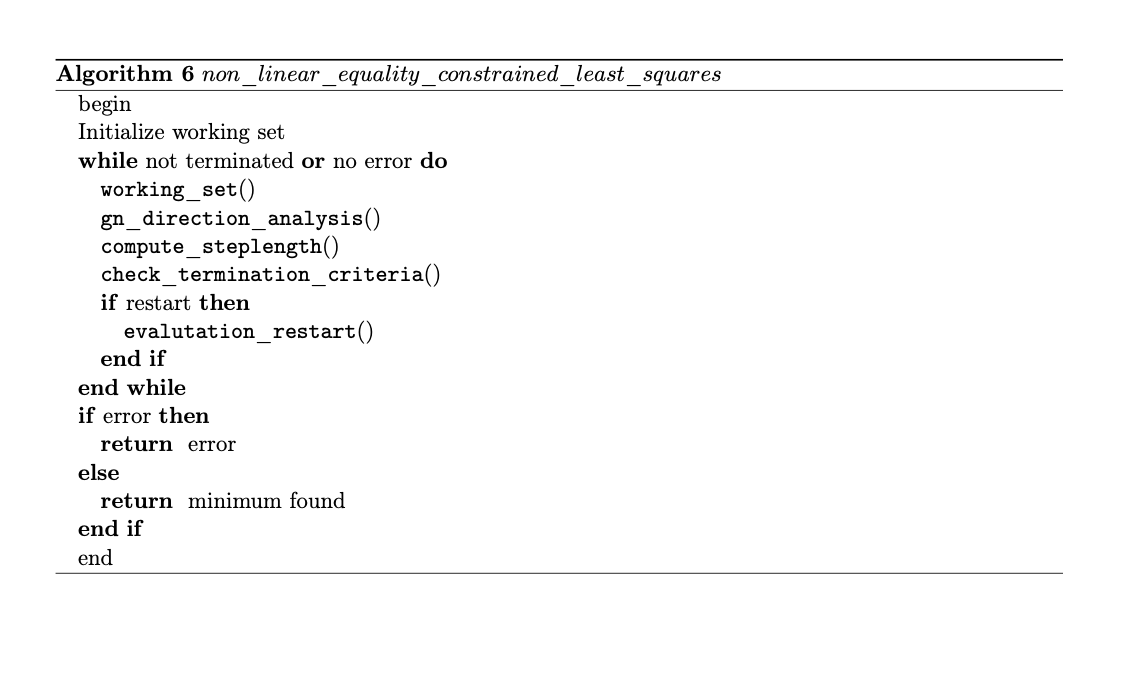



La fonction $\mathtt{init\_working\_set}$ initialise le tableau $K$ des pénalités et le premier vecteur de poids et détermine les contraintes actives au point initial. Les tableaux entiers $active \in \mathbb{N}^l$  et $inactive\in \mathbb{N}^{l-q}$ sont également initialisés.

S'il y a $t$ contraintes actives, donc $l-t$ contraintes inactives, pour $i \leq t, \ active(i)$ est l'indice de la $i^{ème}$ contrainte active et vaut $0$ pour $i > t$. De même, $inactive(j)$ est l'indice de la $j^{ème}$ contrainte inactive si $j \leq l-t$ et $0$ sinon. 

In [30]:
# Equivalent Fortran : INIALC in dblmod2nls.f

function init_working_set(cx::Vector, K::Array{Array{Float64,1},1}, step::Iteration, q::Int64)
    δ, ϵ, ε_rel = 0.1, 0.01, sqrt(eps(Float64))
    l = length(cx)
    
    # Initialisation des pénalités
    K[:] = [δ * ones(l) for i=1:length(K)]
    for i=1:l
        pos = min(abs(cx[i]) + ϵ, δ)
        step.w[i] = pos
    end
    
    # Determination du premier ensemble actif
    active = zeros(Int64, l); inactive = zeros(Int64, l - q)
    t = q; lmt = l - t
    
    # Les contraintes d'égalité sont toujours actives
    active[1:q] = [i for i=1:q]
    
    for i = q+1:l
        if cx[i] <= ε_rel
            t += 1; active[t] = i
        else
            lmt += 1; inactive[lmt] = i
        end
    end
    
    return active, inactive
end 

init_working_set (generic function with 1 method)

La fonction $\mathtt{working\_set}$ met à jour les nouveaux multiplicateurs de Lagrange et calcule la direction de Gauss-Newton.

In [31]:
# Equivalent Fortran : WRKSET in dblwrkset.f

function working_set(rx::Vector, cx::Vector, A::Matrix, J::Matrix, ∇fx::Vector, active::Vector, inactive::Vector,
        qr_AT::QRPivoted{Float64,Array{Float64,2}}, qr_L11::QRPivoted{Float64,Array{Float64,2}}, 
        qr_J2::QRPivoted{Float64,Array{Float64,2}}, q::Int64, rankA::Int64, rankJ2::Int64, 
        previous_step::Iteration)
    
    l = length(active)
    # Calcul de la direction Gauss-Newton avant suppression des contraintes
    p_gn, b_gn, d_gn = gn_search(rx, cx, A, J, qr_AT, qr_L11, qr_J2, rankA, rankJ2)
    
    λ = first_lagrange_mult_estimate(qr_AT, ∇fx)
    s = check_constraint_deletion(q, A, ∇fx, previous_step.β, d_gn)
    
    if s != 0
        
        # Suppression de la contrainte active n°s
        A = A[setdiff(1:end,s),:]
        t = length(λ)
        delete_constraint(active, inactive, s, t, l)
        deleteat!(λ, s); deleteat!(cx, s)
        t -= 1
        previous_step.del = true
        
        # Mise à jour des factorisations QR
        qr_AT = qr(transpose(A), Val(true))
        qr_L11 = qr(transpose(qr_AT.R), Val(true))
        qr_J2 = qr((J * qr_AT.Q)[:, t+1:n], Val(true))
        rankA = rank(LowerTriangular(transpose(qr_AT.R)), atol = ε_rank, rtol = ε_rank)
        rankJ2 = rank(UpperTriangular(qr_J2.R), atol = ε_rank, rtol = ε_rank)
        
        p_gn, b_gn, d_gn = gn_search(rx, cx, A, J, qr_AT, qr_L11, qr_J2, rankA, rankJ2)
    else
        # La première estimation des multiplicateurs n'implique pas de suppression de contrainte
        λ = second_lagrange_mult_estimate(qr_AT, p_gn, rx, J)
        s = check_constraint_deletion(q, A, ∇fx, previous_step.β, d_gn)
        
        if s !=0
            
            # Suppression de la contrainte active n°s
            A = A[setdiff(1:end,s),:]
            t = length(λ)
            delete_constraint(active, inactive, s, t, l)
            deleteat!(λ, s); deleteat!(cx, s)
            t-=1
            previous_step.del = true

            # Mise à jour des factorisations QR
            qr_AT = qr(transpose(A), Val(true))
            qr_L11 = qr(transpose(qr_AT.R), Val(true))
            qr_J2 = qr((J * qr_AT.Q)[:, t+1:n], Val(true))
            rankA = rank(LowerTriangular(transpose(qr_AT.R)), atol = ε_rank, rtol = ε_rank)
            rankJ2 = rank(UpperTriangular(qr_J2.R), atol = ε_rank, rtol = ε_rank)

            p_gn, b_gn, d_gn = gn_search(rx, cx, A, J, qr_AT, qr_L11, qr_J2, rankA, rankJ2)
        else
            previous_step.del = false
        end
        
    end
    previous_step.λ = λ[:]
    return p_gn, b_gn, d_gn, A, qr_AT, qr_L11, qr_J2
end    

working_set (generic function with 1 method)

La fonction $\mathtt{gn\_direction\_analysis}$ analyse la qualité de la direction de descente calculée avec Gauss-Newton. Si elle n'est pas acceptée, une autre analyse détermine quelle méthode est à utiliser pour la recalculer. Les paramètres de l'itération en cours sont modifiés en conséquence.  

In [32]:
# Equivalent Fortran : ANALYS in dblreduns.f

function gn_direction_analysis(x::Vector, p_gn::Vector, r::Function, c::Function, A::Matrix, J::Matrix, 
        b_gn::Vector, d_gn::Vector, active::Vector, inactive::Vector, rankA::Int64, rankJ2::Int64, 
        previous_step::Iteration, λ::Vector, q::Int64,
    qr_AT::QRPivoted{Float64,Array{Float64,2}}, qr_L11::QRPivoted{Float64,Array{Float64,2}},
    qr_J2::QRPivoted{Float64,Array{Float64,2}})
    
    method_code = check_gn_direction(x, r, c, J, A, d_gn, b_gn, rankA, rankJ2, active, inactive, previous_step) 
    previous_step.code = method_code
    
    # Gauss-Newton direction accepted
    if method_code == 1
        previous_step.b, previous_step.d = d_gn[:], b_gn[:]
        previous_step.ω1, previous_step.ω2 = rankA, rankJ2
        previous_step.restart = false
        previous_step.p = p_gn[:]
        return p_gn
    
    # Subspace minimization is suggested
    elseif method_code == -1
        ω1, ω2, b_sub, d_sub = subspace_dimension(x, r, c, J, A, qr_AT, qr_L11, qr_J2, previous_step)
        JQ1 = J * qr_AT.Q
        p_sub = sub_search_direction(r(x), c(x), J * qr_AT.Q, qr_AT, qr_L11, qr_J2, rankA, ω2, ω1)
        previous_step.b, previous_step.d = d_sub[:], b_sub[:]
        previous_step.ω1, previous_step.ω2 = ω1, ω2
        previous_step.restart = false
        previous_step.p = p_sub[:]
        return p_sub
        
    # Newton method is suggested
    else
        p_n = newton_search_direction(x, A, J, r, c, qr_AT, qr_L11, λ, active, rankA, q, previous_step)
        n,t = size(A)
        previous_step.ω1, previous_step.ω2 = -t , t - n
        previous_step.p = p_n[:]
        return p_n
    end
end

gn_direction_analysis (generic function with 1 method)

La fonction $\mathtt{compute\_steplength\_constrained}$ calcule le nouveau vecteur de poids et le pas pour l'itération en cours.

In [54]:
# Equivalent Fortran : STPLNG in dblmod2nls.f

function compute_steplength(r::Function, J::Matrix, c::Function, A::Matrix, x::Vector, 
        active::Vector, inactive::Vector, p::Vector, K::Array{Array{Float64,1},1}, 
        previous_step::Iteration, weight_norm::Int64)
    
    
    # Calcul du vecteur de pénalité de l'itération en cours
    
    w = compute_penalty_weights(r(x), J, c(x), A, x, p, active, inactive, K, weight_norm, previous_step)


    
    # Borne supérieure du pas
    α_upper = upper_bound_steplength(c(x), A, p, inactive)
    α_low = α_upper / 3000
    
    # Première estimation du pas (utilisée comme valeur initiale)
    α0 = min(1, 3 * previous_step.α, α_upper)
    
    # Si la direction est une direction de Newton, le pas vaut nécessairement 1
    if previous_step.code == 2
        α = 1.
    else
        α = linesearch_constrained(r, J, c, A, x, p, w, active, inactive, α0, α_low, α_upper) 
    end
    return α, w
end

compute_steplength (generic function with 1 method)

La fonction $\mathtt{check\_violated\_constraints!}$ vérifie si certaines contraintes d'inégalité deviennent actives au nouveau point $x+\alpha p$. Les tableaux $inactive$ et $active$ sont alors modifiés en place pour prendre en compte ces nouvelles contraintes actives à la prochaine itération.

In [60]:
# Equivalent Fortran : EVADD in dblreduns.f
# A retravailler pour vérifier si cela correspond bien à ce qui est fait dans le code Fortran

function check_violated_constraints!(cx::Vector, active::Vector, inactive::Vector, step::Iteration)
    ε_rel = sqrt(eps(Float64))
    t = count(i -> (i != 0), active); l = length(active)
    s = 1; constraint_added = false
    while inactive[s] != 0
        
        # La contrainte s devient active
        if cx[inactive[s]] <= ε_rel
            add_constraint!(active, inactive, s, t, l)
            step.add = true
            t -= 1
        else
            s += 1
        end
    end
end

check_violated_constraints! (generic function with 1 method)

In [56]:
# Equivalent Fortran : EVREST in dblreduns.f
# evalutaton_restart temporaire
# A retravailler

function evaluation_restart!(previous_step::Iteration)
    if previous_step.restart
        println("\n ==== Restart ==== \n")
        previous_step.restart = false
    end
end     

evaluation_restart! (generic function with 1 method)

# Algorithme de résolution d'un problème de moindres carrés non linéaire avec contraintes d'égalité

$\mathtt{nlecls}$ : Non Linear Equality Constrained Least Squares

In [75]:
# Fonction main pour faire tourner l'algorithme

nlecls = Iteration([0.], [0.], 3., [0.], [0.], 0, 0, [0.], [0.], 0., false, true, false, false, 2)

function (nlecls::Iteration)(x0::Vector, r::Function, c::Function, jac_r::Function, jac_c::Function, q::Int64)
    
    x = x0[:]
    rx, cx, J, A = r(x), c(x), jac_r(x), jac_c(x)
    l, n = size(A)
    p = zeros(n)
    ε_rank = sqrt(eps(Float64))
    iter = 0
    nlecls.λ, nlecls.w = zeros(l), zeros(l)
    
    # Fonction objectif
    f(x::Vector) = 0.5 * dot(r(x),r(x))
    ∇f = x::Vector -> ForwardDiff.gradient(f, x)
    
    # Vecteur de poids et fonction de mérite
    ξ = 4
    K = [zeros(l) for i=1:ξ]
    
    # Premier ensemble actif
    active, inactive = init_working_set(cx, K, nlecls, q)
    t = count(i -> (i > 0), active)
    
    nlecls.x, nlecls.p,  = x[:], p[:]
    nlecls.β = norm(r(x))
    nlecls.ω1, nlecls.ω2 = t, n-t
    nlecls.b, nlecls.d = zeros(n), zeros(n)
    

    terminated = false
    println("Point de départ :")
    show(nlecls)
    while !terminated && iter < 100
        
        Â = A[[active[i] for i=1:l if active[i] != 0],:]
        t = count(i -> (i > 0), active)
        # Factorisations QR et calculs de rang
        qr_AT = qr(transpose(Â), Val(true))
        L11 = transpose(qr_AT.R)
        Q1 = qr_AT.Q
        P1 = qr_AT.P

        qr_L11 = qr(transpose(qr_AT.R), Val(true))
        qr_J2 = qr((J * qr_AT.Q)[:, t+1:n], Val(true))
        
        rankA = rank(LowerTriangular(transpose(qr_AT.R)), atol = ε_rank, rtol = ε_rank)
        rankJ2 = rank(UpperTriangular(qr_J2.R), atol = ε_rank, rtol = ε_rank)
        
        p_gn, b_gn, d_gn, Â, qr_AT, qr_L11, qr_J2 = working_set(rx, cx, Â, J, ∇f(x), active, inactive, qr_AT, qr_L11, qr_J2, q, rankA, rankJ2, nlecls)
        println("p_gn = $p_gn")
        p = gn_direction_analysis(x, p_gn, r, c, Â, J, b_gn, d_gn, active, inactive, rankA, rankJ2, nlecls, nlecls.λ, q, qr_AT, qr_L11, qr_J2)
        println("p = $p")
        α, w = compute_steplength(r, J, c, A, x, active, inactive, p, K, nlecls, 2)
        
        # Mise à jour du point selon la méthode utilisée
        
        if nlecls.code == 2
            nlecls.α = 1.
            x += p[:]
        else
            nlecls.α = α
            x += α * p[:]
        end
        
        if nlecls.restart evaluation_restart!(nlecls) end
        
        nlecls.p = p[:]
        nlecls.w = w[:]
        rx, cx, J, A = r(x), c(x), jac_r(x), jac_c(x)
        
        terminated = check_termination_criterias(x, p, rx, cx, Â, ∇f(x), active , inactive, q, nlecls)
        check_violated_constraints!(cx, active, inactive, nlecls)
        nlecls.x = x[:]
        if iter == 0 nlecls.first = false end
        
        iter += 1
        println("\n Itération n°$iter")
        show(nlecls)
    end
    return x
end

<b> Commentaires </b>

Le main ci-dessus est, selon moi, à retravailler. Il n'est pas assuré que les ensembles active et inactive soient correctement mis à jour. De même pour les factorisations QR.
